 ### Курсовая работа по дисциплине “Технологии анализа данных и машинного обучения ” 
 ### на тему: «Выявление вредоносного программного обеспечения по заголовкам файлов»

In [226]:
from sklearn.preprocessing import normalize, StandardScaler
from sklearn.utils import resample
from sklearn.datasets import make_classification
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import RandomForestClassifier

In [227]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

In [228]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
import gensim
from gensim.models import Word2Vec

In [229]:
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.metrics import accuracy_score
import nltk

import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
from nltk.tokenize import word_tokenize
from nltk.tokenize import word_tokenize, sent_tokenize
import re

Класс AData включает в себе основные функции в работе с датасетом необходимые для его обработки и подготовки к дальнейшему обучению: загрузка файла, рисование диаграмм, изменение размерности, разделение на обучающую и тестовую выборку, векторизация текста.

In [385]:
class AData:
    data = pd.read_csv('pe_section_headers.csv',delimiter=',')
    n_data=data
    
    df_0 = data[data.malware == 0] #создаем два поднабора данных для 0 и 1 
    df_1 = data[data.malware == 1]

    def __init__(self):
        self.size = None
        
    def load_data(self,file):
        self.data=pd.read_csv(file,delimiter=',')
        self.n_data=self.data
        print(self.data)
        
    def graph(self):
        sns.countplot(self.n_data['malware'])
        plt.show()
        
    def change_size(self,size):
        self.size=size
        df_1_sample = resample(self.df_1,
                           replace=False,    
                           n_samples=self.size,  #задаем значение сколько нам нужно данных 
                           random_state=1)
        # объединяются в новый набор классов
        self.n_data = pd.concat([self.df_0, df_1_sample])
        # смотрим на изменение размера классов
        print(self.n_data.malware.value_counts())
        
    def x_y(self,target_name,X_name):
        y = self.n_data[target_name]
        X = self.n_data[X_name]
        return X,y
    
    def del_c(self,target_name,del_name):
        y = self.n_data[target_name]
        X = self.n_data.drop(['hash',target_name], axis=1)
        return X,y
        
    def split(self,X,y,size_testa=0.2):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=size_testa, shuffle=True,random_state=True)
        
        return X_train, X_test, y_train, y_test
    
    def vect(self,X_train, X_test):
        vectorizer = CountVectorizer()
        X_train = vectorizer.fit_transform(X_train)
        X_test = vectorizer.transform(X_test)
        return X_train,X_test
        
    

In [231]:
d=AData()
#d.change_size(3000)

In [232]:
data=d.n_data
data

,hash,size_of_data,virtual_address,entropy,virtual_size,malware
0,071e8c3f8922e186e57548cd4c703a5d,443392,4096,6.529624,442984,1
1,33f8e6d08a6aae939f25a8e0d63dd523,331264,4096,6.604314,330784,1
2,b68abd064e975e1c6d5f25e748663076,74240,4096,6.046789,73819,1
3,72049be7bd30ea61297ea624ae198067,219648,4096,6.497018,219524,1
4,c9b3700a77facf29172f32df6bc77f48,262144,4096,6.638142,261943,1
...,...,...,...,...,...,...
43288,9b917bab7f32188ae40c744f2be9aaf8,286720,4096,6.585726,286359,1
43289,35a18ee05f75f04912018d9f462cb990,262144,4096,6.638142,261943,1
43290,654139d715abcf7ecdddbef5a84f224b,262144,4096,6.638142,261943,1
43291,078c9d4e7be4819a06974c6f292a4857,443392,4096,6.529624,442984,1


Описание:
Датасет содержит данные статистического анализа (заголовки разделов PE секций .text, .code и CODE). Примеры вредоносных программ были взяты с сайта virusshare.com, а примеры программного обеспечения с portableapps.com и из каталогов Windows 7 x86. 
- В hash находятся названия файлов, хешированные с помощью 128-битного алгоритма под названием MD5, представлены в строковом формате. 
- size_of_data целочисленного формата, содержит данные размере файла на диске. 
- virtual_address тоже является атрибутом с целыми числами, содержит данные об адресе памяти первого байта раздела относительно базы изображения. 
- entropy содержит числа с плавающей точкой (float), тут находятся данные о расчетной энтропии раздела. 
- virtual_size формата integer, тут находится информация о первоначальном размере файла при загрузке.
- атрибут malware является категориальным. В данном столбце можно узнать является файл вредоносным (1) или нет (0). 

#### Анализ датасета

In [233]:
data.shape #размер датафрейма

(43293, 6)

In [234]:
print(data.isna().sum()) #проверяю на наличие пропусков

hash               0
size_of_data       0
virtual_address    0
entropy            0
virtual_size       0
malware            0
dtype: int64


In [235]:
data.info() #все атрибуты кроме hash имеют числовые значения

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43293 entries, 0 to 43292
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   hash             43293 non-null  object 
 1   size_of_data     43293 non-null  int64  
 2   virtual_address  43293 non-null  int64  
 3   entropy          43293 non-null  float64
 4   virtual_size     43293 non-null  int64  
 5   malware          43293 non-null  int64  
dtypes: float64(1), int64(4), object(1)
memory usage: 2.0+ MB


In [236]:
data.nunique() #malware - является категориальным признаком. hash надо проверить на наличие дубликатов, тк 
#уникальных значений меньше, чем общего количества значений

hash               43144
size_of_data        2659
virtual_address      129
entropy            17613
virtual_size       11715
malware                2
dtype: int64

/Users/Katty/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


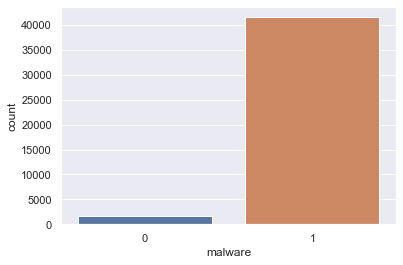

In [237]:
sns.countplot(data['malware'])
plt.show()

### предобработка датасета

In [238]:
data.duplicated().sum() #найдено 24 дубликата, посмотрим на них

24

In [239]:
data[data.duplicated()] #вывелись все дубликаты, то есть у них совпадают значения во всех шести колонках. 
#хоть их и немного, но все равно лучше удалю, что провести обучение на максимально чистых и не повторяющихся 
#данных

,hash,size_of_data,virtual_address,entropy,virtual_size,malware
7719,a32a382b8a5a906e03a83b4f3e5b7a9b,51712,4096,6.611199,51549,0
10428,9600d4ff16bd7e21b1a4f534a2327849,47616,4096,6.464158,47210,0
13380,45ea2362bc248bc57395239a5aa490af,602624,4096,6.383961,602244,0
14518,075323e77815ee8bcc7854ce23955a15,35840,4096,6.305845,35752,0
16715,bdaaac3fa3f6796825a51ef1c0e5b3fd,2247168,4096,6.598922,2247161,0
20041,3d8a7a97ea954dd4fe66279df2b445e0,1950720,4096,6.650195,1950553,0
20937,01061d1982f34394e39cde33153c19f4,44032,4096,6.475128,43802,0
21232,79b78bb3d583748040c41ded09555fd3,28672,4096,6.497885,28432,0
21418,03384ab6368b68ed16ecb9e6352539af,35328,4096,6.275874,34856,0
21969,45ea2362bc248bc57395239a5aa490af,602624,4096,6.383961,602244,0


In [240]:
data = data[~data.duplicated()] #убираем повторы

In [241]:
data.duplicated().sum() #проверяем правильно ли все сработало

0

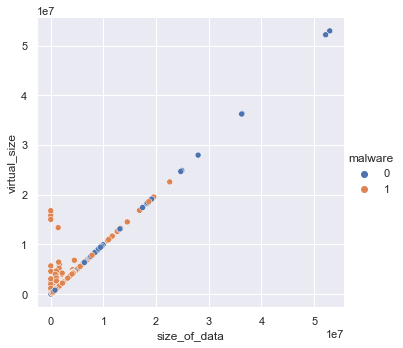

In [242]:
sns.relplot(data=data,x="size_of_data",y="virtual_size",hue="malware")

In [243]:
X,y=d.x_y('malware','hash')
X_train, X_test, y_train, y_test=d.split(X,y)

In [244]:
X_train, X_test=d.vect(X_train, X_test)

In [245]:
X_train.shape

(34634, 34540)

Класс для обучения с помощью алгоритмов машинного обучения.  На вход идут данные, на основе которых будет обучаться модель и название алгоритма, который будет использоваться при обучение. 
С помощью функций класса MLClassifier можно обучить, предсказать, построить матрицу ошибок и вывести значение метрик.

In [246]:
class MLClassifier:
    def __init__(self):
        self.alpha = 0.01
        #self.feature_count_=feature_count_
        #self.force_alpha=force_alpha
        self.clf = None

    def fit(self, X_train, y_train, name_model):
        if name_model=='mnb':
            self.clf = MultinomialNB(alpha=self.alpha)
            self.clf.fit(X_train, y_train)
        elif name_model=='lr':
            self.clf = LogisticRegression(C=10,warm_start=True)
            self.clf.fit(X_train, y_train)
        elif name_model=='rfc':     
            self.clf = RandomForestClassifier(max_depth=1000,min_samples_leaf=1)
            self.clf.fit(X_train, y_train)
        else:
            print('вы неправильно вбили название модели. попробуйте еще раз (mnb,lr,rfc)')
            self.fit(X_train, y_train,str(input()))

    def predict(self, X_test):
        return self.clf.predict(X_test)

    def evaluate(self, X_test, y_test):
        y_pred = self.predict(X_test)
        matrix = metrics.confusion_matrix(y_test, y_pred)
        fig, ax = plt.subplots(figsize=(10, 10))
        sns.heatmap(pd.DataFrame(matrix), annot=True)
        plt.ylabel('Действительные значения')
        plt.xlabel('Предсказанные значения')
        print(metrics.classification_report(y_test, y_pred))
        return accuracy_score(y_test, y_pred)

### Машинное обучение
#### обучение на текстовых данных

##### Модель 1. MultinomialNB

              precision    recall  f1-score   support

           0       0.90      0.03      0.05       345
           1       0.96      1.00      0.98      8314

    accuracy                           0.96      8659
   macro avg       0.93      0.51      0.52      8659
weighted avg       0.96      0.96      0.94      8659



0.9610809562305116

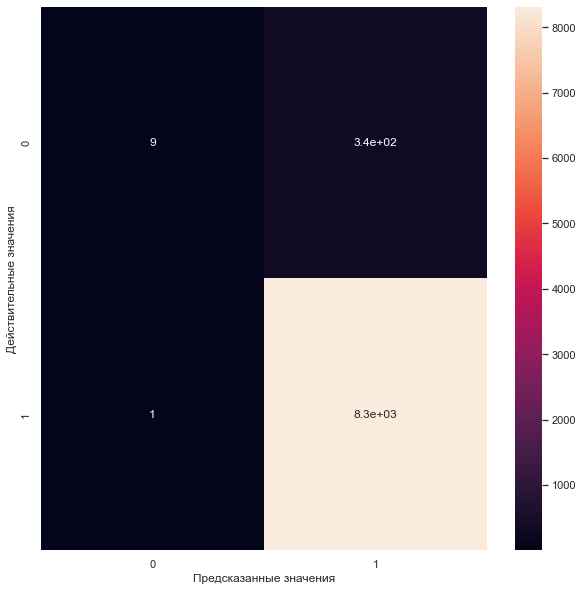

In [383]:
mnb = MLClassifier()
mnb.fit(X_train, y_train, 'mnb')
mnb.evaluate(X_test, y_test)

##### Модель 2. LogisticRegression

              precision    recall  f1-score   support

           0       0.90      0.03      0.05       345
           1       0.96      1.00      0.98      8314

    accuracy                           0.96      8659
   macro avg       0.93      0.51      0.52      8659
weighted avg       0.96      0.96      0.94      8659



0.9610809562305116

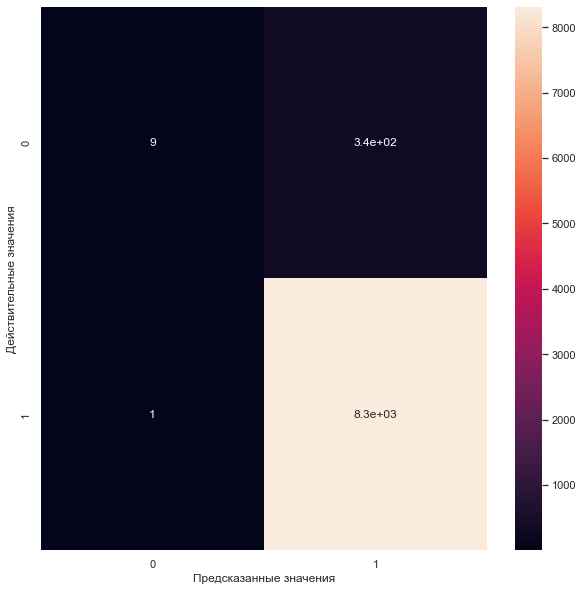

In [248]:
lr = MLClassifier()
lr.fit(X_train, y_train, 'lr')
lr.evaluate(X_test, y_test)

##### Модель 3. RandomForestClassifier

              precision    recall  f1-score   support

           0       0.90      0.03      0.05       345
           1       0.96      1.00      0.98      8314

    accuracy                           0.96      8659
   macro avg       0.93      0.51      0.52      8659
weighted avg       0.96      0.96      0.94      8659



0.9610809562305116

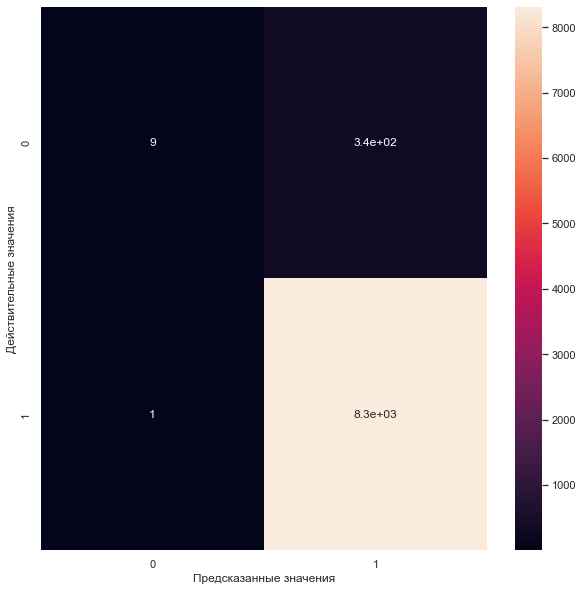

In [249]:
rfc = MLClassifier()
rfc.fit(X_train, y_train, 'rfc')
rfc.evaluate(X_test, y_test)

Класс LearningCurvePlotter создает объект для построения кривой обучения модели. Он принимает модель, данные для обучения и тестирования, параметры кросс-валидации и метрику оценки. Метод plot_learning_curve() строит кривую обучения, отображая зависимость метрики оценки от размера обучающей выборки. Кривая обучения позволяет оценить, насколько хорошо модель обучается на различных объемах данных

In [251]:

from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt

class LearningCurvePlotter:
    def __init__(self, model, X, y, cv=None, train_sizes=None, scoring=None):
        self.model = model
        self.X = X
        self.y = y
        self.cv = cv
        self.train_sizes = train_sizes
        self.scoring = scoring
        
    def plot_learning_curve(self):
        train_sizes, train_scores, test_scores = learning_curve(
            estimator=self.model,
            X=self.X,
            y=self.y,
            cv=self.cv,
            train_sizes=self.train_sizes,
            scoring=self.scoring
        )
        
        train_scores_mean = np.mean(train_scores, axis=1)
        train_scores_std = np.std(train_scores, axis=1)
        test_scores_mean = np.mean(test_scores, axis=1)
        test_scores_std = np.std(test_scores, axis=1)
        
        plt.figure(figsize=(10, 7))
        plt.title("Learning Curve")
        plt.xlabel("Training Examples")
        plt.ylabel("Score")
        plt.grid()
        
        plt.fill_between(
            train_sizes,
            train_scores_mean - train_scores_std,
            train_scores_mean + train_scores_std,
            alpha=0.1,
            color="r"
        )
        
        plt.fill_between(
            train_sizes,
            test_scores_mean - test_scores_std,
            test_scores_mean + test_scores_std,
            alpha=0.1,
            color="g"
        )
        
        plt.plot(
            train_sizes,
            train_scores_mean,
            'o-',
            color="r",
            label="Training Score"
        )
        
        plt.plot(
            train_sizes,
            test_scores_mean,
            'o-',
            color="g",
            label="Cross-validation Score"
        )
        
        plt.legend(loc="best")
        
        return plt.show()


In [252]:
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(X)
y = y

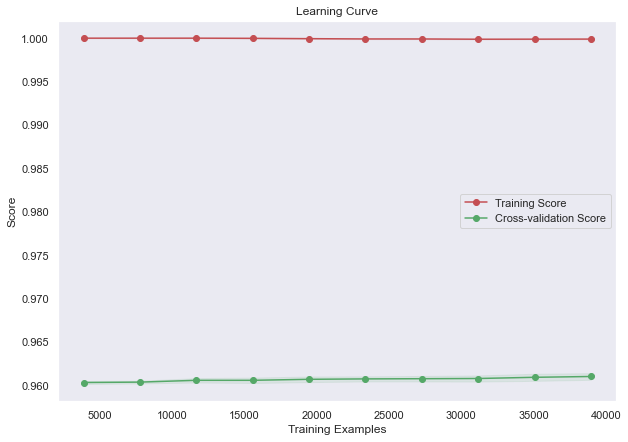

In [253]:


from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

model = MultinomialNB(alpha=0.01)
plotter = LearningCurvePlotter(model, X, y, cv=10, train_sizes=np.linspace(.1, 1.0, 10))
plotter.plot_learning_curve()


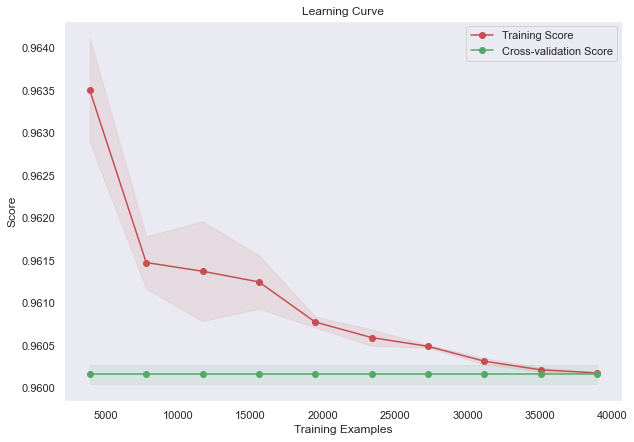

In [254]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier


model = LogisticRegression()
plotter = LearningCurvePlotter(model, X, y, cv=10, train_sizes=np.linspace(.1, 1.0, 10))
plotter.plot_learning_curve()

In [255]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer

## глубокое обучение

In [257]:
import torch.nn as nn


Класс Vocab создает словарь из символов, используемых в данных.

In [258]:
class Vocab: 
    
    def __init__(self, data):
        
        self.idx_to_token = {}
        self.token_to_idx = {}
        self.gennerate_vocab(data)
        self.vocab_len = len(self.token_to_idx)
    
    #добавляет новый токен в словарь, если он еще не был добавлен ранее
    def add_token(self, token):
        if token not in self.token_to_idx:
            self.token_to_idx[token] = len(self.token_to_idx) 
            self.idx_to_token[len(self.idx_to_token)] = token
            
    #Метод generate_vocab проходит по всем данным и добавляет каждый символ в словарь с 
    #помощью метода add_token
    def gennerate_vocab(self, data):
        for hash in data:
            for char in hash:
                self.add_token(char)

In [364]:
d.change_size(3000)
data=d.n_data
hash_data = data["hash"].unique().astype('str')  # строка unicode длиной до 32 символов
hash_data

1    3000
0    1725
Name: malware, dtype: int64


array(['a32a382b8a5a906e03a83b4f3e5b7a9b',
       '5b51d65972a349f90a86984c26b12b30',
       'ca66c2f1ddaca8a4e682917a9b833e86', ...,
       'c291f99f8d91266c70edeef769b8f8fd',
       '03ffb97a373fb83ec651b50d3e69cd97',
       'b3f4ba7a8b3ddaf2fc6efa3cb774f889'], dtype='<U32')

In [365]:
vocab = Vocab(hash_data) # в итоге каждому токену соответствует индекс
vocab.idx_to_token
vocab.token_to_idx

{'a': 0,
 '3': 1,
 '2': 2,
 '8': 3,
 'b': 4,
 '5': 5,
 '9': 6,
 '0': 7,
 '6': 8,
 'e': 9,
 '4': 10,
 'f': 11,
 '7': 12,
 '1': 13,
 'd': 14,
 'c': 15}

In [366]:
from nltk.corpus import stopwords, wordnet
import string
stop_words = set(stopwords.words("english"))
lemmatizer = nltk.WordNetLemmatizer()
punctuation = set(string.punctuation)

In [367]:
class HashDataset(Dataset):
    def __init__(self, X, y, vocab: Vocab):
        self.X = X
        self.y = y
        self.vocab = vocab
    
    def vectorize(self, hash):
        #Генерирует представление hash при помощи бинарного кодирования
        #Векторизируем с помощь вокаба, выдает вектор, которым будет закодирована строка'
        repr = torch.zeros(self.vocab.vocab_len)
        for char in preprocess_text(hash):
            idx = self.vocab.token_to_idx[char]
            repr[idx] = 1
        return repr
    
    def __getitem__(self, idx) -> tuple:
        return self.vectorize(self.X[idx]), targets[idx]
    
    def __len__(self) -> int:
        return len(self.X)
    
    def __str__(self) -> str:
        return f"HashDataset with {self.__len__()} items"
    
    def y_len(self) -> int:
        return self.y.unique().shape[0]

In [368]:
from torch.utils.data import Dataset, DataLoader, random_split

In [369]:
import torch

dataset =HashDataset(
    data["hash"].tolist(),
    torch.tensor(data["malware"].to_numpy(), dtype=torch.long),
    vocab
)


print(dataset)

#делим на обучающую и тестовую
train_size = int(len(dataset)*0.8)
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])
#упорядочивает данные и упрощает конвейер машинного обучения. Это позволяет нам повторять данные, 
#управлять партиями и перемешивать выборки, чтобы избежать переобучения.
trainloader = torch.utils.data.DataLoader(train_dataset, batch_size = 32, shuffle = True, pin_memory=True)
testloader = torch.utils.data.DataLoader(test_dataset, batch_size = 1, pin_memory = True)

print(f"train_size : {train_size}")
print(f"test_size : {test_size}")

HashDataset with 4725 items
train_size : 3780
test_size : 945


Эта функция тестирует модель, используя набор данных, представленный в dataloader. Она вычисляет потери и точность модели на тестовых данных и выводит результаты.

In [370]:
def test_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0
    model.eval()

    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

Эта функция обучает модель на тренировочных данных, используя набор данных, представленный в dataloader. Она вычисляет потери и обновляет параметры модели на каждом батче данных, используя оптимизатор optimizer

In [371]:
def train_loop(
        dataloader,
        model,
        loss_fn,
        optimizer,
        verbose = 500,
        device = "cpu",
) -> torch.Tensor:
    model.train()

    size = len(dataloader.dataset)  # noqa
    num_batches = len(dataloader)
    avg_loss = 0

    for batch, (x, y) in enumerate(dataloader):
        x, y = x.to(device), y.to(device)

        pred = model(x)
        loss = loss_fn(pred, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        avg_loss += loss
        if batch % verbose == 0:
            print(f"loss: {loss:>7f}  [{batch * len(x):>5d}/{size:>5d}]")

        del x, y, pred, loss
        torch.cuda.empty_cache()

    return avg_loss / num_batches

In [372]:
# Формируем модель
class NeuralNetwork(nn.Module):
    def __init__(self, in_features, out_features):
        # создает последовательность слоев, которая включает в себя два линейных слоя (nn.Linear) 
        # с функцией активации ReLU (nn.ReLU), последний линейный слой и функцию активации LogSoftmax 
        # (nn.LogSoftmax). 

        super(NeuralNetwork, self).__init__()
        self.seq = nn.Sequential(  #создаем слои 
            nn.Linear(in_features, 1024),
            nn.ReLU(), #используется в нейронных сетях для добавления нелинейности
          
            nn.Linear(1024, out_features),
            nn.LogSoftmax(dim=1), #Функция активации LogSoftmax преобразует вектор значений в 
                                #вероятностное распределение, где каждый элемент вектора описывает вероятность 
                                #принадлежности объекта к определенному классу
        )
        #in_features и out_features - это размерность входных и выходных данных

    def forward(self, inputs):
        return self.seq(inputs)

In [373]:
import torch.nn as nn
import torch.optim as optim

In [374]:
#Определяем необходимые элементы для обучения
model = NeuralNetwork(vocab.vocab_len, dataset.y_len())
loss_fn = nn.NLLLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
train_dataloader = DataLoader(train_dataset, batch_size=1)
test_dataloader = DataLoader(test_dataset, batch_size=1)

In [375]:
targets=torch.tensor(data["malware"].to_numpy(), dtype=torch.long) 
targets

tensor([0, 0, 0,  ..., 1, 1, 1])

In [376]:
def preprocess_text(text: str) -> str: #обработка текста
    return text

In [377]:
losses_plt = []

epochs = 100
losses = torch.empty(epochs)


for t in range(epochs): 
    print(f"Epoch {t+1}\n-------------------------------")
    buf = train_loop(train_dataloader, model, loss_fn, optimizer)
    losses[t] = buf
    losses_plt.append(buf.item())
    test_loop(test_dataloader, model, loss_fn)
    
print("Готов")

Epoch 1
-------------------------------
loss: 0.726544  [    0/ 3780]
loss: 0.647567  [  500/ 3780]
loss: 0.494652  [ 1000/ 3780]
loss: 1.268679  [ 1500/ 3780]
loss: 0.429334  [ 2000/ 3780]
loss: 0.431295  [ 2500/ 3780]
loss: 0.632964  [ 3000/ 3780]
loss: 0.564392  [ 3500/ 3780]
Test Error: 
 Accuracy: 67.1%, Avg loss: 0.642585 

Epoch 2
-------------------------------
loss: 0.494008  [    0/ 3780]
loss: 0.577316  [  500/ 3780]
loss: 0.492131  [ 1000/ 3780]
loss: 1.268650  [ 1500/ 3780]
loss: 0.419730  [ 2000/ 3780]
loss: 0.417683  [ 2500/ 3780]
loss: 0.592717  [ 3000/ 3780]
loss: 0.541090  [ 3500/ 3780]
Test Error: 
 Accuracy: 67.1%, Avg loss: 0.643113 

Epoch 3
-------------------------------
loss: 0.498880  [    0/ 3780]
loss: 0.552010  [  500/ 3780]
loss: 0.484116  [ 1000/ 3780]
loss: 1.255063  [ 1500/ 3780]
loss: 0.411051  [ 2000/ 3780]
loss: 0.411791  [ 2500/ 3780]
loss: 0.572142  [ 3000/ 3780]
loss: 0.531627  [ 3500/ 3780]
Test Error: 
 Accuracy: 67.1%, Avg loss: 0.643549 

Epoc

loss: 0.277657  [ 3000/ 3780]
loss: 0.414858  [ 3500/ 3780]
Test Error: 
 Accuracy: 65.7%, Avg loss: 0.666980 

Epoch 26
-------------------------------
loss: 0.401690  [    0/ 3780]
loss: 0.393560  [  500/ 3780]
loss: 0.349867  [ 1000/ 3780]
loss: 0.984698  [ 1500/ 3780]
loss: 0.294396  [ 2000/ 3780]
loss: 0.355994  [ 2500/ 3780]
loss: 0.267557  [ 3000/ 3780]
loss: 0.411405  [ 3500/ 3780]
Test Error: 
 Accuracy: 65.8%, Avg loss: 0.667947 

Epoch 27
-------------------------------
loss: 0.400867  [    0/ 3780]
loss: 0.396732  [  500/ 3780]
loss: 0.343218  [ 1000/ 3780]
loss: 0.972591  [ 1500/ 3780]
loss: 0.291442  [ 2000/ 3780]
loss: 0.354161  [ 2500/ 3780]
loss: 0.264038  [ 3000/ 3780]
loss: 0.407958  [ 3500/ 3780]
Test Error: 
 Accuracy: 65.7%, Avg loss: 0.669071 

Epoch 28
-------------------------------
loss: 0.391370  [    0/ 3780]
loss: 0.395169  [  500/ 3780]
loss: 0.338644  [ 1000/ 3780]
loss: 0.959101  [ 1500/ 3780]
loss: 0.284902  [ 2000/ 3780]
loss: 0.354094  [ 2500/ 3780]
l

loss: 0.273189  [ 1000/ 3780]
loss: 0.899443  [ 1500/ 3780]
loss: 0.192169  [ 2000/ 3780]
loss: 0.332486  [ 2500/ 3780]
loss: 0.169245  [ 3000/ 3780]
loss: 0.377201  [ 3500/ 3780]
Test Error: 
 Accuracy: 62.9%, Avg loss: 0.687731 

Epoch 51
-------------------------------
loss: 0.275842  [    0/ 3780]
loss: 0.360686  [  500/ 3780]
loss: 0.269243  [ 1000/ 3780]
loss: 0.902252  [ 1500/ 3780]
loss: 0.189581  [ 2000/ 3780]
loss: 0.330047  [ 2500/ 3780]
loss: 0.165871  [ 3000/ 3780]
loss: 0.378063  [ 3500/ 3780]
Test Error: 
 Accuracy: 62.9%, Avg loss: 0.688661 

Epoch 52
-------------------------------
loss: 0.266907  [    0/ 3780]
loss: 0.361882  [  500/ 3780]
loss: 0.268634  [ 1000/ 3780]
loss: 0.900052  [ 1500/ 3780]
loss: 0.182097  [ 2000/ 3780]
loss: 0.331953  [ 2500/ 3780]
loss: 0.159161  [ 3000/ 3780]
loss: 0.376622  [ 3500/ 3780]
Test Error: 
 Accuracy: 63.2%, Avg loss: 0.689407 

Epoch 53
-------------------------------
loss: 0.272271  [    0/ 3780]
loss: 0.361393  [  500/ 3780]
l

loss: 0.331411  [  500/ 3780]
loss: 0.214483  [ 1000/ 3780]
loss: 0.916611  [ 1500/ 3780]
loss: 0.122648  [ 2000/ 3780]
loss: 0.320604  [ 2500/ 3780]
loss: 0.123245  [ 3000/ 3780]
loss: 0.365764  [ 3500/ 3780]
Test Error: 
 Accuracy: 61.3%, Avg loss: 0.711192 

Epoch 76
-------------------------------
loss: 0.200858  [    0/ 3780]
loss: 0.334808  [  500/ 3780]
loss: 0.219456  [ 1000/ 3780]
loss: 0.912434  [ 1500/ 3780]
loss: 0.124879  [ 2000/ 3780]
loss: 0.317704  [ 2500/ 3780]
loss: 0.123434  [ 3000/ 3780]
loss: 0.366895  [ 3500/ 3780]
Test Error: 
 Accuracy: 61.3%, Avg loss: 0.711674 

Epoch 77
-------------------------------
loss: 0.215285  [    0/ 3780]
loss: 0.319772  [  500/ 3780]
loss: 0.214091  [ 1000/ 3780]
loss: 0.919875  [ 1500/ 3780]
loss: 0.123377  [ 2000/ 3780]
loss: 0.320192  [ 2500/ 3780]
loss: 0.126961  [ 3000/ 3780]
loss: 0.359326  [ 3500/ 3780]
Test Error: 
 Accuracy: 61.3%, Avg loss: 0.712967 

Epoch 78
-------------------------------
loss: 0.206286  [    0/ 3780]
l

Test Error: 
 Accuracy: 60.8%, Avg loss: 0.734348 

Epoch 100
-------------------------------
loss: 0.181068  [    0/ 3780]
loss: 0.293438  [  500/ 3780]
loss: 0.169363  [ 1000/ 3780]
loss: 0.920908  [ 1500/ 3780]
loss: 0.097739  [ 2000/ 3780]
loss: 0.321393  [ 2500/ 3780]
loss: 0.105479  [ 3000/ 3780]
loss: 0.360844  [ 3500/ 3780]
Test Error: 
 Accuracy: 60.8%, Avg loss: 0.735136 

Готов


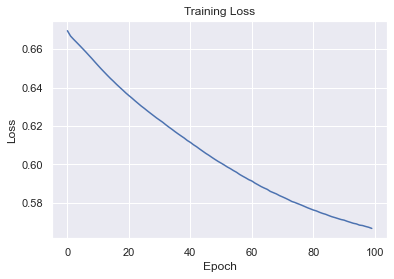

In [379]:
import matplotlib.pyplot as plt

plt.plot(torch.arange(len(losses_plt)), losses_plt)
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

In [380]:
# Получаем данные с тестовой выборки
y_pred = []
y_true = []

for inputs, labels in test_dataloader:
    output = model(inputs) # Feed Network
    output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
    y_pred.extend(output) # Save Prediction
    labels = labels.data.cpu().numpy()
    y_true.extend(labels) # Save Truth

In [381]:
from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred, target_names=list({'0': 0, '1': 1})))

              precision    recall  f1-score   support

           0       0.32      0.17      0.23       311
           1       0.67      0.82      0.74       634

    accuracy                           0.61       945
   macro avg       0.50      0.50      0.48       945
weighted avg       0.56      0.61      0.57       945



Text(0.5, 66.5, 'Предсказанные значения')

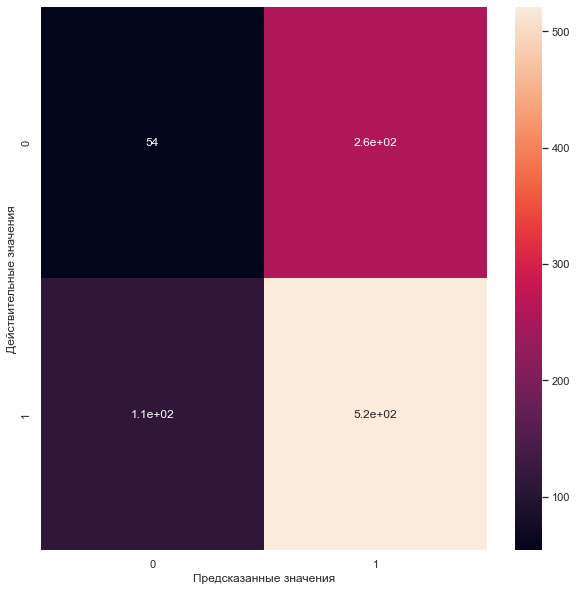

In [382]:
matrix = metrics.confusion_matrix(y_true, y_pred)

fig, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(pd.DataFrame(matrix), annot=True)
plt.ylabel('Действительные значения')
plt.xlabel('Предсказанные значения')

Используя модель NeuralNetwork качество предсказания безопасного ПО увеличилось, хоть и хуже стал предсказывать вредоносное ПО. 

---

### Теперь тоже самое, только с числовыми данными (virtual_size,size_of_data,entropy, virlual_address)  

я решила провести обучение на числовых данных, тк заметила что обучение по заголовкам файлов не всегда корректно. поэтому эта часть работы решает вопрос удобно ли вообще обнаружать вреденосное ПО по заголовкам файлов

In [389]:
d=AData()
X,y=d.del_c('malware','hash')
X_train, X_test, y_train, y_test=d.split(X,y)

### Машинное обучение
#### обучение на числовых данных

##### Модель 1. MultinomialNB

              precision    recall  f1-score   support

           0       0.03      0.21      0.05       345
           1       0.95      0.68      0.79      8314

    accuracy                           0.66      8659
   macro avg       0.49      0.44      0.42      8659
weighted avg       0.92      0.66      0.76      8659



0.66012241598337

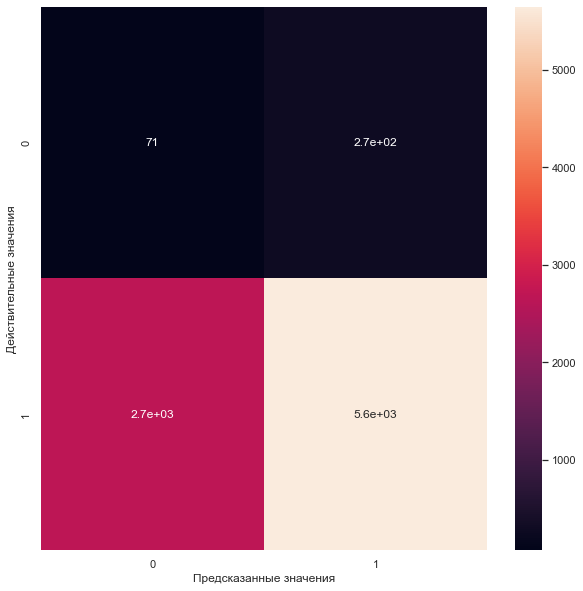

In [390]:
mnb = MLClassifier()
mnb.fit(X_train, y_train, 'mnb')
mnb.evaluate(X_test, y_test)

##### Модель 2. LogisticRegression

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       345
           1       0.96      1.00      0.98      8314

    accuracy                           0.96      8659
   macro avg       0.48      0.50      0.49      8659
weighted avg       0.92      0.96      0.94      8659



/Users/Katty/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/Katty/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/Katty/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.9601570620163992

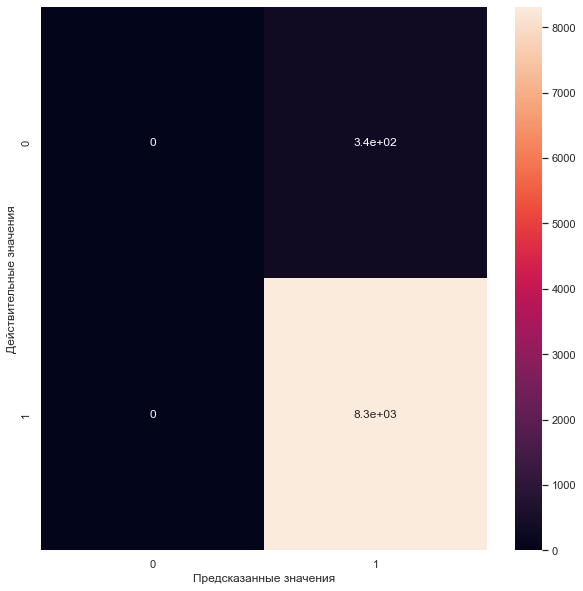

In [391]:
lr = MLClassifier()
lr.fit(X_train, y_train, 'lr')
lr.evaluate(X_test, y_test)

##### Модель 3. RandomForestClassifier

              precision    recall  f1-score   support

           0       0.64      0.44      0.52       345
           1       0.98      0.99      0.98      8314

    accuracy                           0.97      8659
   macro avg       0.81      0.72      0.75      8659
weighted avg       0.96      0.97      0.96      8659



0.9677791892828271

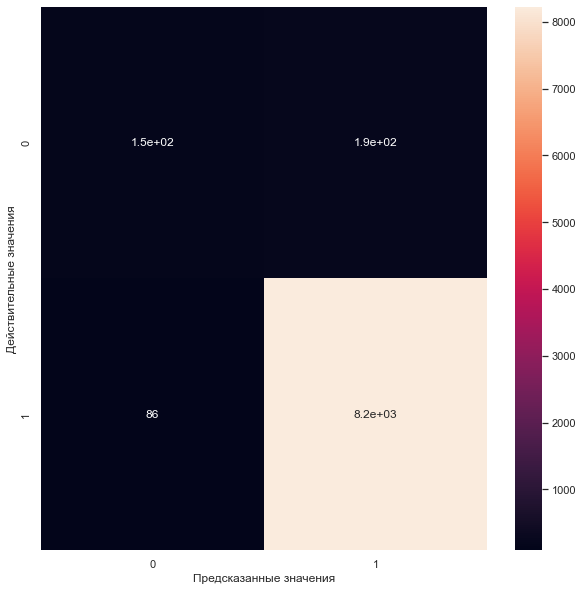

In [392]:
rfc = MLClassifier()
rfc.fit(X_train, y_train, 'rfc')
rfc.evaluate(X_test, y_test)